# Homework

* We split the continuous action space into 11 discrete actions. Increase the number (to 15, 25, 35 etc) to test the three DQN versions and compare the results.

In [58]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections

In [59]:
# Define the environment name
env_name = 'Pendulum-v1'

# Create the environment
env = gym.make(env_name)

# Define the state dimension
state_dim = env.observation_space.shape[0]
env.reset(seed=0)

array([ 0.6520163 ,  0.758205  , -0.46042657], dtype=float32)

In [60]:
# Define the function to convert discrete actions to continuous actions
def dis_to_con(discrete_action, env, num_actions):
    action_lowbound = env.action_space.low[0]  # Minimum of continuous action space
    action_upbound = env.action_space.high[0]  # Maximum of continuous action space
    return action_lowbound + (discrete_action / (num_actions - 1)) * (action_upbound - action_lowbound)

In [61]:
# Define the Q-network architecture
class Qnet(torch.nn.Module):
    ''' Q-network with a single hidden layer '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [62]:
# Define the Dueling Q-network architecture
class VAnet(torch.nn.Module):
    ''' Dueling Q-network '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        V = self.fc_V(F.relu(self.fc1(x)))
        A = self.fc_A(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

In [63]:
# Define the Replay Buffer
class ReplayBuffer:
    ''' Experience replay buffer '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # Allocate memory

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

In [70]:
# Define the DQN class
class DQN:
    ''' DQN, Double DQN, and Dueling DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [68]:
# Define the training function
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()  # Modified here to only get the state
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])  # Modified here to only unpack three values
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward  # Reward is calculated here
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns,
                                           'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                      'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list

## VanillaDQN

Training and evaluating DQNs with 11 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s, episode=200, return=-187.247]


Training and evaluating DQNs with 15 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s, episode=200, return=-210.258]


Training and evaluating DQNs with 25 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s, episode=200, return=-214.245]


Training and evaluating DQNs with 35 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s, episode=200, return=-358.171]


Training and evaluating DQNs with 45 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s, episode=200, return=-446.941]


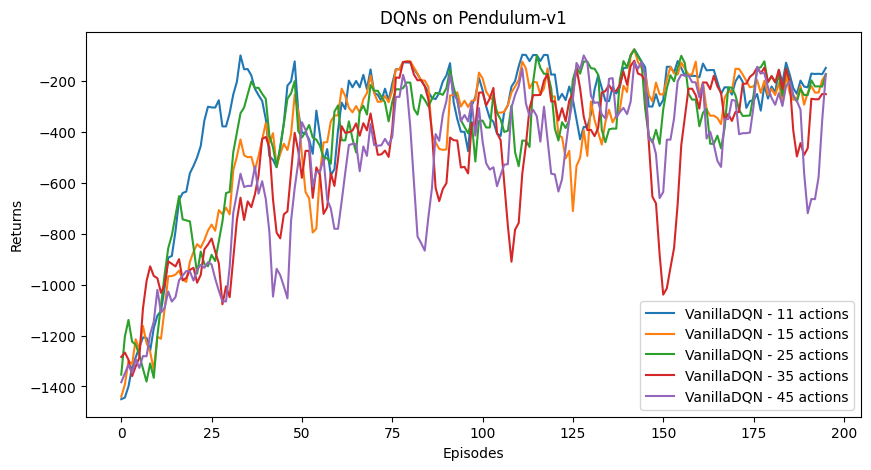

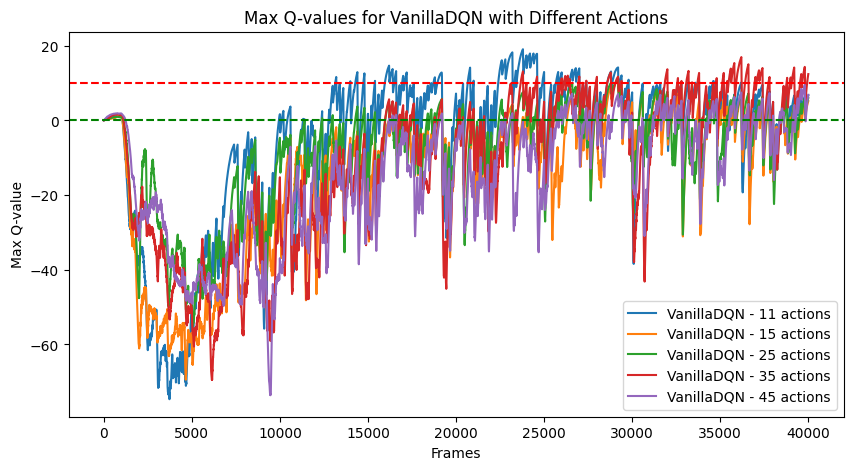

In [33]:
def train_and_evaluate_dqns(num_actions_list):
    # Initialize dictionaries to store max Q-values and returns for each DQN type
    q_values_dict = {'VanillaDQN': {}}
    returns_dict = {'VanillaDQN': {}}

    for num_actions in num_actions_list:
        print(f"Training and evaluating DQNs with {num_actions} discrete actions...")
        env.reset(seed=0)
        env.action_dim = num_actions

        lr = 1e-2
        num_episodes = 200
        hidden_dim = 128
        gamma = 0.98
        epsilon = 0.01
        target_update = 50
        buffer_size = 5000
        minimal_size = 1000
        batch_size = 64
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        replay_buffer = ReplayBuffer(buffer_size)

        for dqn_type in ['VanillaDQN']:
            agent = DQN(state_dim, hidden_dim, num_actions, lr, gamma, epsilon, target_update, device, dqn_type)
            return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

            # Store the max Q-values and returns for each DQN type
            q_values_dict[dqn_type][num_actions] = max_q_value_list
            returns_dict[dqn_type][num_actions] = return_list

    # Plot the returns for each episode
    plt.figure(figsize=(10, 5))
    for dqn_type, returns in returns_dict.items():
        for num_actions, return_list in returns.items():
            episodes_list = list(range(len(return_list)))
            mv_return = moving_average(return_list, 5)
            episodes_list = episodes_list[:len(mv_return)]  # Adjust the length of episodes_list
            plt.plot(episodes_list, mv_return, label=f'{dqn_type} - {num_actions} actions')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'DQNs on {env_name}')
    plt.legend()
    plt.show()

    # Plot the max Q-values for each DQN type
    plt.figure(figsize=(10, 5))
    for dqn_type, q_values in q_values_dict.items():
        for num_actions, q_values_list in q_values.items():
            plt.plot(q_values_list, label=f'{dqn_type} - {num_actions} actions')
    plt.axhline(0, c='green', ls='--')
    plt.axhline(10, c='red', ls='--')
    plt.xlabel('Frames')
    plt.ylabel('Max Q-value')
    plt.title(f'Max Q-values for {dqn_type} with Different Actions')
    plt.legend()
    plt.show()

# Call the function with the desired range of action dimensions
train_and_evaluate_dqns([11, 15, 25, 35, 45])

## DoubleDQN

Training and evaluating DQNs with 11 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s, episode=200, return=-206.760]


Training and evaluating DQNs with 15 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s, episode=200, return=-308.572]


Training and evaluating DQNs with 25 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s, episode=200, return=-282.738]


Training and evaluating DQNs with 35 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s, episode=200, return=-319.087]


Training and evaluating DQNs with 45 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s, episode=200, return=-351.623]


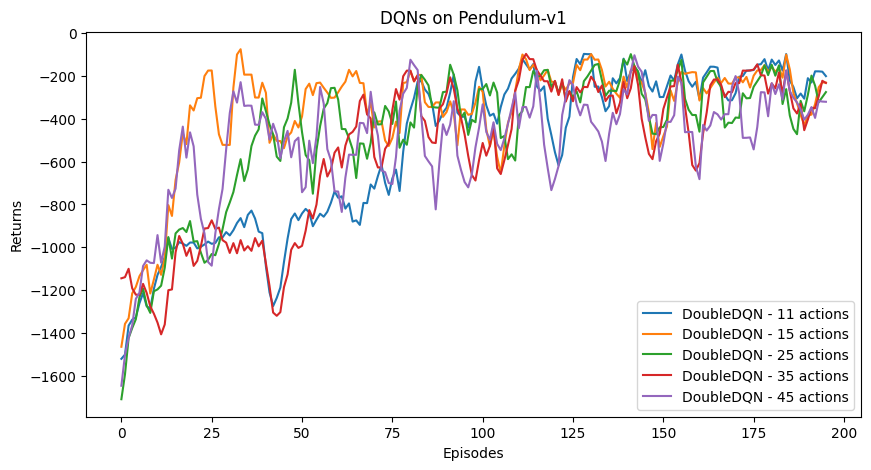

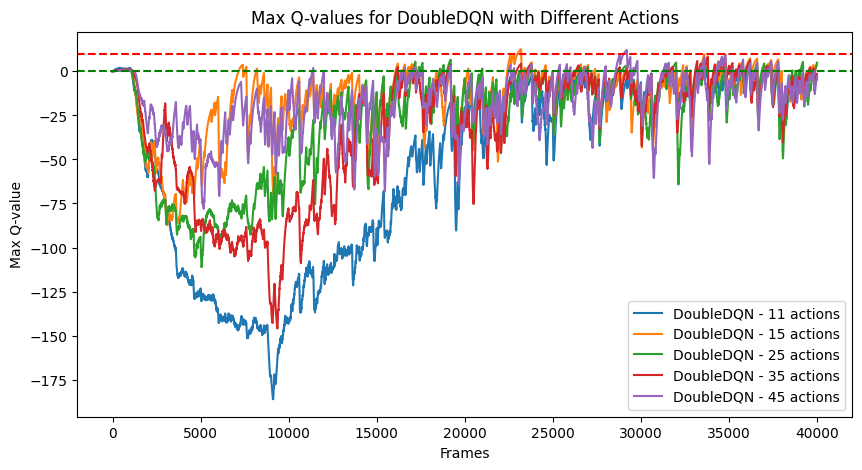

In [34]:
def train_and_evaluate_dqns(num_actions_list):
    # Initialize dictionaries to store max Q-values and returns for each DQN type
    q_values_dict = {'DoubleDQN': {}}
    returns_dict = {'DoubleDQN': {}}

    for num_actions in num_actions_list:
        print(f"Training and evaluating DQNs with {num_actions} discrete actions...")
        env.reset(seed=0)
        env.action_dim = num_actions

        lr = 1e-2
        num_episodes = 200
        hidden_dim = 128
        gamma = 0.98
        epsilon = 0.01
        target_update = 50
        buffer_size = 5000
        minimal_size = 1000
        batch_size = 64
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        replay_buffer = ReplayBuffer(buffer_size)

        for dqn_type in ['DoubleDQN']:
            agent = DQN(state_dim, hidden_dim, num_actions, lr, gamma, epsilon, target_update, device, dqn_type)
            return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

            # Store the max Q-values and returns for each DQN type
            q_values_dict[dqn_type][num_actions] = max_q_value_list
            returns_dict[dqn_type][num_actions] = return_list

    # Plot the returns for each episode
    plt.figure(figsize=(10, 5))
    for dqn_type, returns in returns_dict.items():
        for num_actions, return_list in returns.items():
            episodes_list = list(range(len(return_list)))
            mv_return = moving_average(return_list, 5)
            episodes_list = episodes_list[:len(mv_return)]  # Adjust the length of episodes_list
            plt.plot(episodes_list, mv_return, label=f'{dqn_type} - {num_actions} actions')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'DQNs on {env_name}')
    plt.legend()
    plt.show()

    # Plot the max Q-values for each DQN type
    plt.figure(figsize=(10, 5))
    for dqn_type, q_values in q_values_dict.items():
        for num_actions, q_values_list in q_values.items():
            plt.plot(q_values_list, label=f'{dqn_type} - {num_actions} actions')
    plt.axhline(0, c='green', ls='--')
    plt.axhline(10, c='red', ls='--')
    plt.xlabel('Frames')
    plt.ylabel('Max Q-value')
    plt.title(f'Max Q-values for {dqn_type} with Different Actions')
    plt.legend()
    plt.show()

# Call the function with the desired range of action dimensions
train_and_evaluate_dqns([11, 15, 25, 35, 45])

## DuelingDQN

Training and evaluating DQNs with 11 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s, episode=200, return=-169.654]


Training and evaluating DQNs with 15 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, episode=200, return=-187.989]


Training and evaluating DQNs with 25 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it, episode=200, return=-208.015]


Training and evaluating DQNs with 35 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:19<00:00,  1.00it/s, episode=200, return=-225.019]


Training and evaluating DQNs with 45 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, episode=200, return=-249.350]


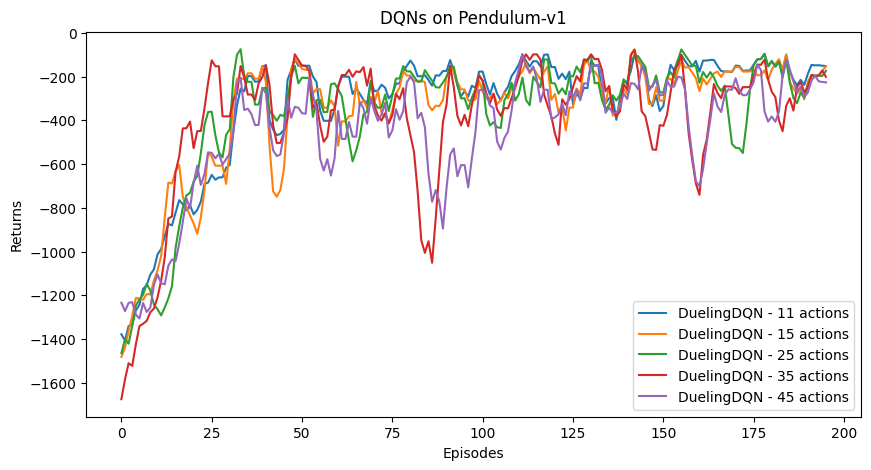

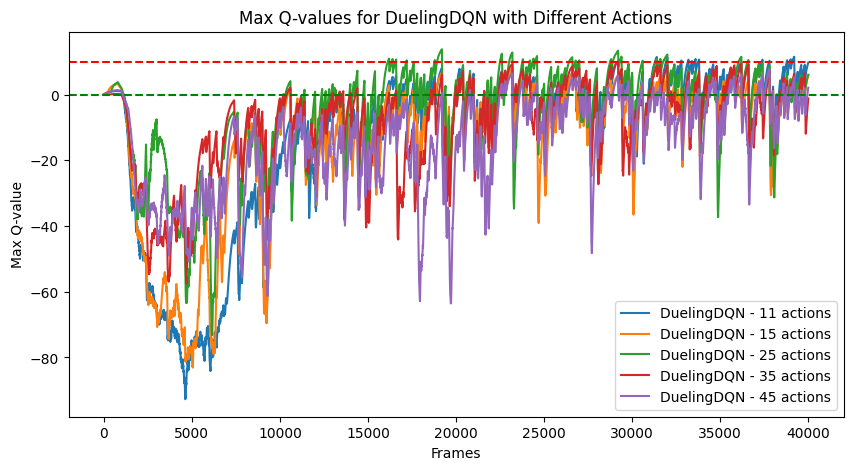

In [35]:
def train_and_evaluate_dqns(num_actions_list):
    # Initialize dictionaries to store max Q-values and returns for each DQN type
    q_values_dict = {'DuelingDQN': {}}
    returns_dict = {'DuelingDQN': {}}

    for num_actions in num_actions_list:
        print(f"Training and evaluating DQNs with {num_actions} discrete actions...")
        env.reset(seed=0)
        env.action_dim = num_actions

        lr = 1e-2
        num_episodes = 200
        hidden_dim = 128
        gamma = 0.98
        epsilon = 0.01
        target_update = 50
        buffer_size = 5000
        minimal_size = 1000
        batch_size = 64
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        replay_buffer = ReplayBuffer(buffer_size)

        for dqn_type in ['DuelingDQN']:
            agent = DQN(state_dim, hidden_dim, num_actions, lr, gamma, epsilon, target_update, device, dqn_type)
            return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

            # Store the max Q-values and returns for each DQN type
            q_values_dict[dqn_type][num_actions] = max_q_value_list
            returns_dict[dqn_type][num_actions] = return_list

    # Plot the returns for each episode
    plt.figure(figsize=(10, 5))
    for dqn_type, returns in returns_dict.items():
        for num_actions, return_list in returns.items():
            episodes_list = list(range(len(return_list)))
            mv_return = moving_average(return_list, 5)
            episodes_list = episodes_list[:len(mv_return)]  # Adjust the length of episodes_list
            plt.plot(episodes_list, mv_return, label=f'{dqn_type} - {num_actions} actions')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'DQNs on {env_name}')
    plt.legend()
    plt.show()

    # Plot the max Q-values for each DQN type
    plt.figure(figsize=(10, 5))
    for dqn_type, q_values in q_values_dict.items():
        for num_actions, q_values_list in q_values.items():
            plt.plot(q_values_list, label=f'{dqn_type} - {num_actions} actions')
    plt.axhline(0, c='green', ls='--')
    plt.axhline(10, c='red', ls='--')
    plt.xlabel('Frames')
    plt.ylabel('Max Q-value')
    plt.title(f'Max Q-values for {dqn_type} with Different Actions')
    plt.legend()
    plt.show()

# Call the function with the desired range of action dimensions
train_and_evaluate_dqns([11, 15, 25, 35, 45])

## Comparison of DQN's and action_dims

Training and evaluating DQNs with 11 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s, episode=200, return=-173.851]


Training and evaluating DQNs with 15 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s, episode=200, return=-159.392]


Training and evaluating DQNs with 25 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s, episode=200, return=-172.796]


Training and evaluating DQNs with 35 discrete actions...


Iteration 9: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s, episode=200, return=-201.176]


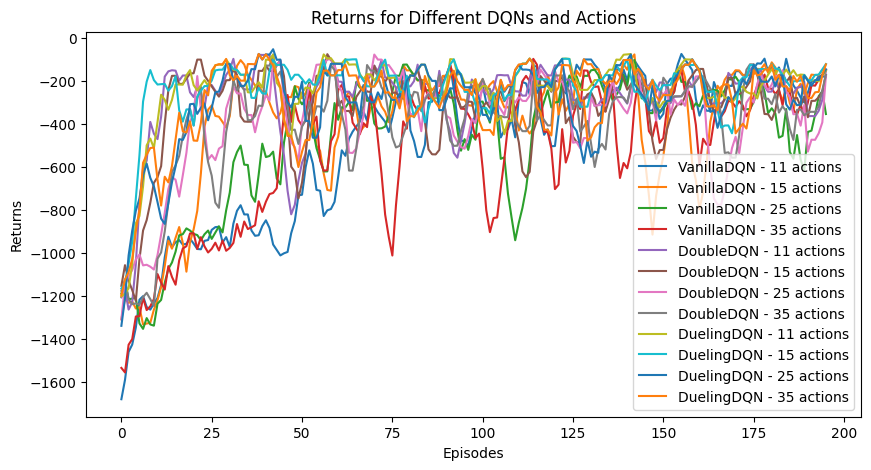

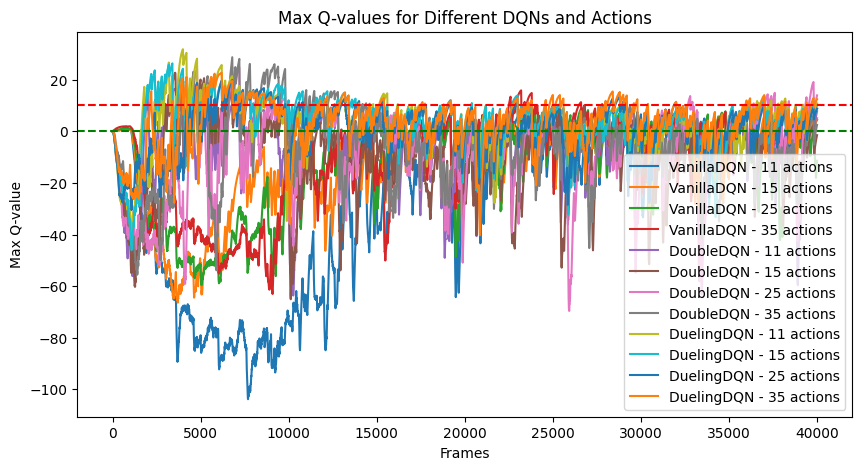

In [73]:
def train_and_evaluate_dqns(num_actions_list, env):
    # Initialize dictionaries to store max Q-values and returns for each DQN type
    q_values_dict = {'VanillaDQN': {}, 'DoubleDQN': {}, 'DuelingDQN': {}}
    returns_dict = {'VanillaDQN': {}, 'DoubleDQN': {}, 'DuelingDQN': {}}

    for num_actions in num_actions_list:
        print(f"Training and evaluating DQNs with {num_actions} discrete actions...")
        env.reset(seed=0)
        env.action_dim = num_actions

        lr = 1e-2
        num_episodes = 200
        hidden_dim = 128
        gamma = 0.98
        epsilon = 0.01
        target_update = 50
        buffer_size = 5000
        minimal_size = 1000
        batch_size = 64
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        replay_buffer = ReplayBuffer(buffer_size)

        for dqn_type in ['VanillaDQN', 'DoubleDQN', 'DuelingDQN']:
            # Initialize the appropriate DQN agent
            agent = DQN(state_dim, hidden_dim, num_actions, lr, gamma, epsilon, target_update, device, dqn_type)

            # Train the agent and get the returns and max Q-values
            return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

            # Store the max Q-values and returns for each DQN type
            q_values_dict[dqn_type][num_actions] = max_q_value_list
            returns_dict[dqn_type][num_actions] = return_list

    # Plot the returns for each episode in one graph
    plt.figure(figsize=(10, 5))
    for dqn_type, returns in returns_dict.items():
        for num_actions, return_list in returns.items():
            episodes_list = list(range(len(return_list)))
            mv_return = moving_average(return_list, 5)
            episodes_list = episodes_list[:len(mv_return)]  # Adjust the length of episodes_list
            plt.plot(episodes_list, mv_return, label=f'{dqn_type} - {num_actions} actions')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title('Returns for Different DQNs and Actions')
    plt.legend()
    plt.show()

    # Plot the max Q-values for each DQN type in one graph
    plt.figure(figsize=(10, 5))
    for dqn_type, q_values in q_values_dict.items():
        for num_actions, q_values_list in q_values.items():
            plt.plot(q_values_list, label=f'{dqn_type} - {num_actions} actions')
    plt.axhline(0, c='green', ls='--')
    plt.axhline(10, c='red', ls='--')
    plt.xlabel('Frames')
    plt.ylabel('Max Q-value')
    plt.title('Max Q-values for Different DQNs and Actions')
    plt.legend()
    plt.show()

# Call the function with the desired range of action dimensions
train_and_evaluate_dqns([11, 15, 25, 35], env)

## Conclusion

#### Returns:
All versions show an upward trend in returns over episodes, indicating that they are learning and improving their policies over time. However, the versions with more actions (35 and 45) seem to achieve higher returns than the versions with fewer actions (11, 15, and 25).

#### Q Value:
All versions show fluctuations in Q-values, which is expected during the learning process. However, the versions with more actions (35 and 45) seem to have a higher Q-value range than the versions with fewer actions (11, 15, and 25).

#### Convergence Speed:
The versions with fewer actions (11 and 15) seem to converge faster than the versions with more actions (25, 35, and 45). This could be due to the increased complexity of the action space in the versions with more actions.

#### Stability:
The versions with more actions (35 and 45) show more fluctuations in returns and Q-values, indicating less stability compared to the versions with fewer actions (11, 15, and 25).

In Total, increasing the number of actions seems to improve the performance (higher returns and Q-values) of the Vanilla DQN on Pendulum-v1, but it may also lead to slower convergence and less stability. Therefore, choosing the number of actions involves a trade-off between performance, convergence speed, and stability.